In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
file_path = 'weather.csv'
data=pd.read_csv(file_path, delimiter=',',header=11,skipinitialspace=True)
data.head(24)

,Year,Month,Day,Hour,Minute,Temperature,Total_Precipitation,Wind_Speed,Wind_Direction
0,2018,1,15,0,0,16.40,0.0,6.73,74.48
1,2018,1,15,1,0,16.27,0.0,6.62,67.62
2,2018,1,15,2,0,16.14,0.0,6.30,59.04
3,2018,1,15,3,0,16.04,0.0,6.30,59.04
4,2018,1,15,4,0,15.97,0.0,6.19,54.46
5,2018,1,15,5,0,15.90,0.0,5.90,52.43
6,2018,1,15,6,0,15.83,0.0,5.86,47.49
7,2018,1,15,7,0,15.85,0.0,5.60,45.00
8,2018,1,15,8,0,16.24,0.0,6.62,45.00
9,2018,1,15,9,0,16.69,0.0,6.37,47.29


In [3]:
temperature = np.array(data['Temperature'])
num_periods = 24
f_horizon = 1
x_data = temperature[:(len(temperature)-(num_periods*2))]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = temperature[1:(len(temperature)-(num_periods*2))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)
print(y_batches.shape)

(14, 24, 1)


In [4]:
def test_data(series, forecast, num):
    testX = temperature[-(num + forecast):][:num].reshape(-1, num_periods, 1)
    testY = temperature[-(num):].reshape(-1, num_periods, 1)
    return testX, testY
X_test, Y_test = test_data(temperature, f_horizon, 24*2)
print(X_test.shape)


(2, 24, 1)


In [5]:
tf.reset_default_graph()
inputs = 1
rnn_size = 100
output = 1
learning_rate=0.001
dropout_keep_prob = tf.placeholder(tf.float32)

X = tf.placeholder(tf.float32, [None, num_periods, 1])
Y = tf.placeholder(tf.float32, [None, num_periods, 1])

rnn_cells=tf.contrib.rnn.BasicRNNCell(num_units=rnn_size, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(rnn_cells, X, dtype=tf.float32)


output=tf.reshape(rnn_output, [-1, rnn_size])
logit=tf.layers.dense(output, 1, name="softmax")

outputs=tf.reshape(logit, [-1, num_periods, 1])
print(logit)

loss = tf.reduce_sum(tf.square(outputs - Y))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logit, 1), tf.cast(Y, tf.int64)), tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step=optimizer.minimize(loss)

init=tf.global_variables_initializer()

Tensor("softmax/BiasAdd:0", shape=(?, 1), dtype=float32)


In [6]:
epochs = 1000

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()

for epoch in range(epochs):
    train_dict = {X: x_batches, Y: y_batches, dropout_keep_prob:0.5}
    sess.run(train_step, feed_dict=train_dict)
y_pred=sess.run(outputs, feed_dict={X: X_test})
save_path = saver.save(sess, "models/weather.ckpt")

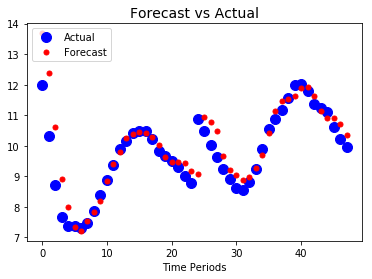

In [7]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")
plt.show()

In [8]:
# test = [10.89, 10.48, 10.03, 9.62, 9.25, 8.92, 8.63, 8.54, 8.83, 9.25, 9.89, 10.54, 10.87, 11.17, 11.57, 12, 12.03, 11.79, 11.37, 11.25, 11.09, 10.61, 10.21, 9.95]
# test = np.array(test)
# test = test.reshape(-1, 24, 1)

# with tf.Session() as sess:
#   # Restore variables from disk.
#     saver.restore(sess, "models/model.ckpt")
#     predict=sess.run(outputs, feed_dict={X: test})
# print(predict)

In [9]:
print(y_pred)

[[[ 13.68329239]
  [ 12.38183689]
  [ 10.6089344 ]
  [  8.90525723]
  [  7.99713326]
  [  7.33862782]
  [  7.21358156]
  [  7.52942085]
  [  7.82835388]
  [  8.19459534]
  [  8.85112   ]
  [  9.4004097 ]
  [  9.78203773]
  [ 10.24088287]
  [ 10.39134216]
  [ 10.45989418]
  [ 10.43076706]
  [ 10.28805923]
  [ 10.02421379]
  [  9.64002323]
  [  9.477314  ]
  [  9.46359253]
  [  9.4336729 ]
  [  9.1907444 ]]

 [[  9.08840084]
  [ 10.92932796]
  [ 10.77638912]
  [ 10.47209549]
  [  9.67250729]
  [  9.20163727]
  [  9.03349495]
  [  8.86497211]
  [  8.97432995]
  [  9.28073502]
  [  9.68797112]
  [ 10.4259758 ]
  [ 11.1420002 ]
  [ 11.45558262]
  [ 11.54124832]
  [ 11.63409233]
  [ 11.8897686 ]
  [ 11.93324947]
  [ 11.64048481]
  [ 11.13520813]
  [ 10.90499592]
  [ 10.90796089]
  [ 10.72305298]
  [ 10.36288071]]]
